In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
import os

from sentinel.storage import SentinelDataset, SentinelDatasetIterator
from mask.mask_dataset import MaskDataset, MaskDatasetIterator
from mask.utils import apply_mask_to_image_series


data_path = '../../kornmo-data-files/raw-data/crop-classification-data/'

In [2]:
print("Reading data")
data = gpd.read_file(f"{data_path}/training_data.gpkg")
data['orgnr'] = data['orgnr'].astype(int)
data['year'] = data['year'].astype(int)

print("Reading masks")
masks = MaskDataset(f"{data_path}/train_data_masks.h5")

print("Reading satellite images")
satellite_imgs = SentinelDataset('E:/MasterThesisData/Satellite_Images/satellite_images_train.h5')



Reading data
Reading masks
Reading satellite images


In [3]:
data = data.loc[data['planted'] != 'erter']
data = data.loc[data['planted'] != 'rughvete']
data = data.loc[data['planted'] != 'oljefro']
data = data.loc[data['planted'] != 'rug']
print(pd.Series(list(data['planted'])).value_counts())
labels = list(set(data['planted']))

def add_labels(orgnr, year, data_arg):
    orgnr = int(orgnr)
    year = int(year)
    if orgnr in data['orgnr'].unique() and year in data.loc[data['orgnr'] == orgnr]['year'].unique():
        label = data.loc[data['orgnr'] == orgnr].loc[data['year'] == year]['planted'].iloc[0]
        index = labels.index(label)
        arr = [0 for _ in range(0, len(labels))]
        arr[index] = 1
        return {'class': arr}
    else:
        return []

bygg     126957
havre     32227
hvete     29149
dtype: int64


In [4]:
train, val = satellite_imgs.to_iterator().split(rand_seed='corn')
train = train.with_data(add_labels, show_progress=True)
val = val.with_data(add_labels, show_progress=True)
masks_it = masks.get_iterator()
mask_dict = {}

for orgnr, year, mask in masks_it:
    mask_dict[f'{orgnr}/{year}'] = mask


train = train.filter(lambda orgnr, year, _,__: f"{orgnr}/{year}" in mask_dict)
val = val.filter(lambda orgnr, year, _,__: f"{orgnr}/{year}" in mask_dict)

print(f"train samples: {len(train)}")
print(f"val samples: {len(val)}")\


100%|██████████| 1961/1961 [00:10<00:00, 185.19it/s]


train samples: 7737
val samples: 1937


In [5]:
#import random

def apply_mask(orgnr, year, imgs):
    mask = mask_dict[f'{orgnr}/{year}']
    return apply_mask_to_image_series(mask, imgs)

def apply_output(orgnr, year, img_source, data):
    label = data['class']
    #num = random.randint(0, 29)
    return {"cnn_input": img_source[0:30]}, label

In [6]:
from tensorflow.python.data.experimental import assert_cardinality

train_dataset = tf.data.Dataset.from_generator(
    train.transform(apply_mask).apply(apply_output).shuffled(),
    output_types=({'cnn_input': tf.dtypes.float64}, tf.dtypes.int64)
).apply(assert_cardinality(len(train)))

val_dataset = tf.data.Dataset.from_generator(
    val.transform(apply_mask).apply(apply_output).shuffled(),
    output_types=({'cnn_input': tf.dtypes.float64}, tf.dtypes.int64)
).apply(assert_cardinality(len(val)))

print(f"training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

training samples: 7737
Validation samples: 1937


In [9]:
from sklearn.utils import class_weight

classes = list(data['planted'])

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weights = dict(zip(np.array([0, 1, 2]), class_weights))

print(class_weights)

{0: 0.49447975823835366, 1: 1.9479835748492464, 2: 2.1536816586046403}


In [20]:
from keras import layers, models


def cnn(input_dim, output_dim):
    input_layer = layers.Input(shape=input_dim)
    y = layers.Conv2D(16, (3, 3), activation=tf.nn.relu, padding='same')(input_layer)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(y)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(y)
    y = layers.MaxPool2D((2, 2))(y)
    y = layers.Flatten()(y)
    y = layers.Dense(output_dim, activation=tf.nn.relu)(y)
    return models.Model(inputs=[input_layer], outputs=[y], name="SingleImageCNN")

In [21]:
from keras.models import load_model
from tensorflow import optimizers, keras


model_checkpoint = keras.callbacks.ModelCheckpoint(
    './training/classification_model.h5',
    monitor="val_loss",
    verbose=1,
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

callbacks = [model_checkpoint]

restart = True
if restart:
    cnn_net = cnn(input_dim=(100, 100, 12), output_dim=64)
    input_cnn = layers.Input(shape=(30, 100, 100, 12), name="cnn_input")

    cnn = layers.TimeDistributed(cnn_net, input_shape=(30, 100, 100, 12))(input_cnn)
    cnn = layers.GRU(64, return_sequences=False)(cnn)
    cnn = layers.Flatten()(cnn)
    cnn = layers.Dense(128)(cnn)
    cnn = layers.Dense(3, activation='softmax')(cnn)

    cnn = models.Model(inputs=[input_cnn], outputs=cnn, name="CNN")

    cnn.compile(
        optimizer=optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )

    print(cnn.summary())


    cnn_history = cnn.fit(
            train_dataset.take(10000).batch(32).prefetch(2),
            validation_data=val_dataset.batch(32).prefetch(2),
            epochs=20,
            verbose=1,
            callbacks=callbacks,
            # class_weight=class_weights
    )
else:
    cnn_net = load_model('./training/classification_model.h5')
    cnn_net.compile(
        optimizer=optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )
    cnn_history = cnn_net.fit(
        train_dataset.take(10000).batch(32).prefetch(2),
        validation_data=val_dataset.batch(32).prefetch(2),
        epochs=10,
        verbose=1,
        callbacks=callbacks
    )

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_input (InputLayer)      [(None, 30, 100, 100, 12  0         
                             )]                                  
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64)           614768    
 tributed)                                                       
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 3)                 387     

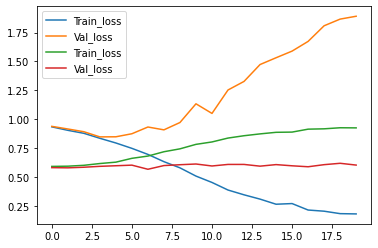

In [30]:
import matplotlib.pyplot as plt

acc=cnn_history.history['categorical_accuracy']
val_acc=cnn_history.history['val_categorical_accuracy']
loss=cnn_history.history['loss']
val_loss=cnn_history.history['val_loss']

plt.plot(loss, label='Train_loss')
plt.plot(val_loss, label='Val_loss')
plt.plot(acc, label='Train_loss')
plt.plot(val_acc, label='Val_loss')
plt.legend()
plt.savefig('classification_param_change.svg')
plt.show()